In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:00<00:00, 131MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fiter_list = [3, 5, 8]

train = pd.read_csv("sample_data/mnist_train_small.csv", header=None, names=["Target"]+[f"Pixel{i}" for i in range(1, 785)])
test = pd.read_csv("sample_data/mnist_test.csv", header=None, names=["Target"]+[f"Pixel{i}" for i in range(1, 785)])

filter_train = train[train["Target"].isin(fiter_list)].reset_index(drop=True)
filter_test = test[test["Target"].isin(fiter_list)].reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from group_lasso import LogisticGroupLasso
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# To demonstate L1 regularized logistic regression
X_train = filter_train.iloc[:, 1:].values
y_train = filter_train['Target'].values
X_test = filter_test.iloc[:, 1:].values
y_test = filter_test['Target'].values

# Scale features first for L1 regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

labels = np.unique(y_train)
records = []

In [ ]:
alpha_seq = np.logspace(-3, 1, 5)
lr_ovr = LogisticRegressionCV(Cs=alpha_seq, cv=5, penalty='l1',
                             solver='saga', multi_class='ovr')
lr_ovr.fit(X_train_scaled, y_train)
y_pred_ovr = lr_ovr.predict(X_test_scaled)
accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
cm_ovr = confusion_matrix(filter_test["Target"], y_pred_ovr, labels=labels)
print("Accuracy:", accuracy_ovr)
print("Confusion Matrix:")
print(cm_ovr)
records.append(("lr_ovr", accuracy_ovr, cm_ovr))

Accuracy: 0.9283727399165508
Confusion Matrix:
[[946  32  32]
 [ 44 809  39]
 [ 32  27 915]]


In [ ]:
C_values = np.logspace(-3, 1, 5)  # C 搜索范围：0.001 ~ 10

lr_mul = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
)
lr_mul.fit(X_train_scaled, y_train)

# 预测
y_pred_mul = lr_mul.predict(X_test_scaled)

# 输出结果
accuracy_mul = accuracy_score(y_test, y_pred_mul)
cm_mul = confusion_matrix(y_test, y_pred_mul, labels=labels)
print("Accuracy:", accuracy_mul)
print("Confusion Matrix:")
print(cm_mul)
records.append(("lr_mul", accuracy_mul, cm_mul))

Accuracy: 0.9283727399165508
Confusion Matrix:
[[944  34  32]
 [ 44 815  33]
 [ 33  30 911]]


In [ ]:
# 训练 Naive Bayes（GaussianNB 适用于连续数据）
nb_clf = GaussianNB()
nb_clf.fit(X_train_scaled, y_train)

# 预测
y_pred_nb = nb_clf.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_nb = accuracy_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)

# 输出结果
print("Naïve Bayes Accuracy:", accuracy_nb)
print("Confusion Matrix:")
print(cm_nb)
records.append(("nb_clf", accuracy_nb, cm_nb))

Naïve Bayes Accuracy: 0.35292072322670376
Confusion Matrix:
[[126 884   0]
 [  5 883   4]
 [  9 959   6]]


In [ ]:
# 训练 LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# 预测
y_pred_lda = lda.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_lda = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda, labels=labels)

# 输出结果
print("LDA Accuracy:", accuracy_lda)
print("Confusion Matrix:")
print(cm_lda)
records.append(("lda", accuracy_lda, cm_lda))

LDA Accuracy: 0.9043810848400556
Confusion Matrix:
[[917  55  38]
 [ 53 792  47]
 [ 31  51 892]]


In [ ]:
for i in range(len(records)-1, 1, -1):
    if records[i][0] == "svm_ovr":
      del records[i]
C_values = np.logspace(-3, 1, 5)  # C 搜索范围：0.001 ~ 10

# 进行超参数搜索
param_grid = {'C': C_values}
svm_ovr = GridSearchCV(LinearSVC(max_iter=10000, dual=False), param_grid, cv=5, scoring='accuracy')
svm_ovr.fit(X_train_scaled, y_train)

# 预测
y_pred_svm = svm_ovr.best_estimator_.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

# 输出结果
print("Best C:", svm_ovr.best_params_['C'])
print("Linear SVM (OvR) Accuracy:", accuracy_svm)
print("Confusion Matrix:")
print(cm_svm)

records.append(("svm_ovr", accuracy_svm, cm_svm))

Best C: 0.001
Linear SVM (OvR) Accuracy: 0.9273296244784422
Confusion Matrix:
[[944  31  35]
 [ 43 812  37]
 [ 31  32 911]]


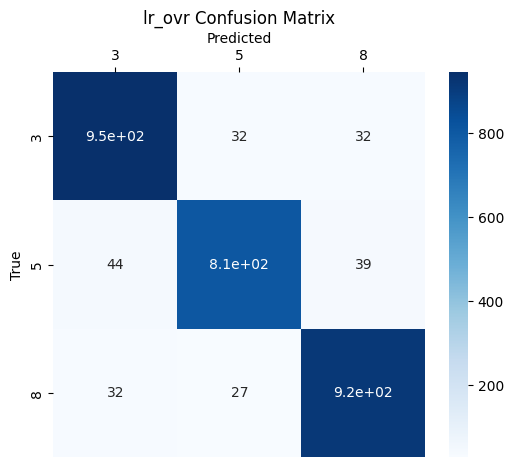

lr_ovr model most often predicts 3 wrong with FPR 7.44%.


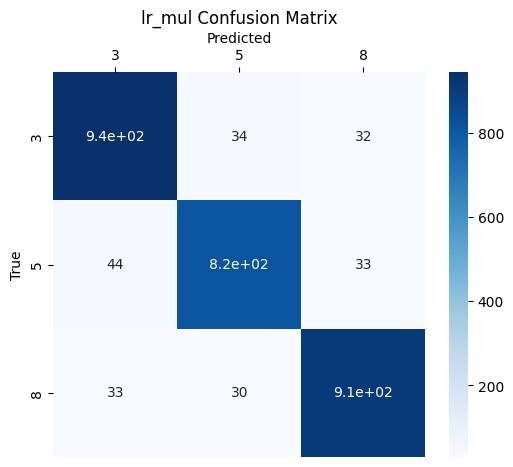

lr_mul model most often predicts 3 wrong with FPR 7.54%.


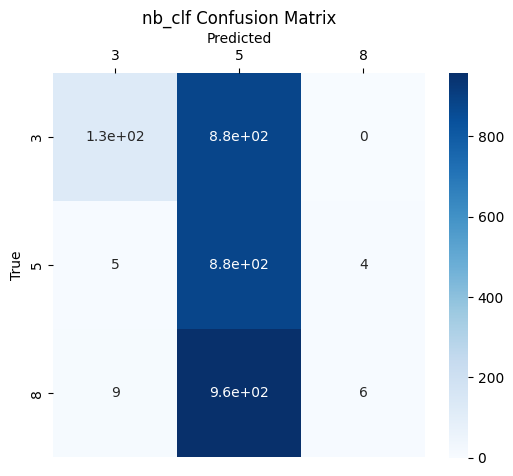

nb_clf model most often predicts 5 wrong with FPR 67.61%.


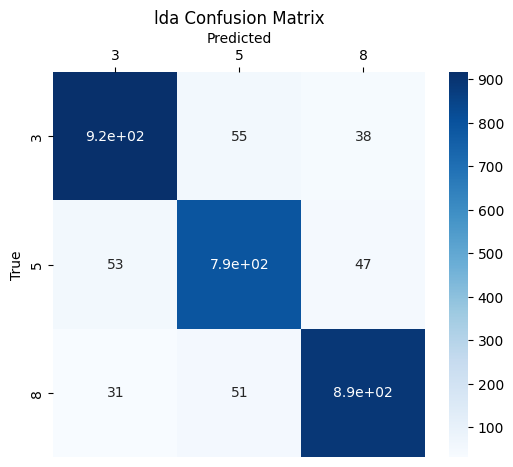

lda model most often predicts 5 wrong with FPR 11.80%.


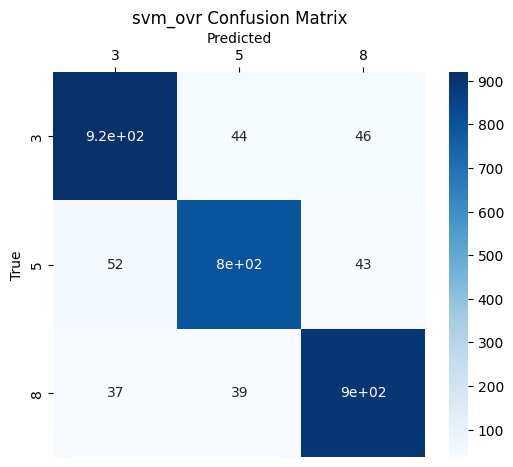

svm_ovr model most often predicts 5 wrong with FPR 9.43%.
--------------------------------------------------
lr_ovr has highest accuracy: 92.84%
The hardest class is 5 with 3 models.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hardest_class = dict()

# 最高准确率模型
max_accuracy = max(records, key=lambda item: item[1])

for item in records:
    # 绘制混淆矩阵
    plt.figure(figsize=(6, 5))
    sns.heatmap(pd.DataFrame(item[2], columns=labels, index=labels), cmap="Blues", annot=True)
    plt.title(f"{item[0]} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.gca().xaxis.set_label_position('top')  # X 轴标签移到上方
    plt.gca().xaxis.tick_top()  # X 轴刻度移到上方
    plt.show()

    # 计算 False Positive Rate (FPR)
    temp = 1 - np.diag(item[2]) / (item[2].sum(axis=0) + 1e-8)  # 避免除以 0
    temp[np.isnan(temp)] = 0  # 处理 NaN
    index_wrong_high = np.argmax(temp)  # 找到 FPR 最高的类别

    # 记录 hardest class
    hardest_class[labels[index_wrong_high]] = hardest_class.get(labels[index_wrong_high], 0) + 1

    # 输出该模型最容易预测错误的类别
    FP = temp[index_wrong_high]
    print(f"{item[0]} model most often predicts {labels[index_wrong_high]} wrong with FPR {FP*100:.2f}%.")

print("-"*50)
print(f"{max_accuracy[0]} has highest accuracy: {max_accuracy[1]*100:.2f}%")

# 找出最难分类的类别
hardest = max(hardest_class, key=hardest_class.get)
print(f"The hardest class is {hardest} with {hardest_class[hardest]} models.")

In [ ]:
sorted(records, key=lambda item: item[1], reverse=True)

[('lr_ovr',
  0.9283727399165508,
  array([[946,  32,  32],
         [ 44, 809,  39],
         [ 32,  27, 915]])),
 ('lr_mul',
  0.9283727399165508,
  array([[944,  34,  32],
         [ 44, 815,  33],
         [ 33,  30, 911]])),
 ('group_lasso',
  0.9262865090403338,
  array([[943,  35,  32],
         [ 39, 815,  38],
         [ 37,  31, 906]])),
 ('svm_ovr',
  0.9092489568845619,
  array([[920,  44,  46],
         [ 52, 797,  43],
         [ 37,  39, 898]])),
 ('lda',
  0.9043810848400556,
  array([[917,  55,  38],
         [ 53, 792,  47],
         [ 31,  51, 892]])),
 ('nb_clf',
  0.35292072322670376,
  array([[126, 884,   0],
         [  5, 883,   4],
         [  9, 959,   6]]))]

Based on the results, I found that logistic regression with One vs Rest has the same performance as multinomial regression, which two outperform other models in accuracy.

1- Naive bayes and LDA prefer the gausian situation.
2-

In [ ]:
# 定义 Group Lasso 模型
group_lasso = LogisticGroupLasso(groups=np.arange(X_train_scaled.shape[1]),
                                 group_reg=0.01, l1_reg=0,
                                 supress_warning=True)

# 训练模型
group_lasso.fit(X_train, y_train)

# 预测 logits
y_pred_gl = group_lasso.predict(X_test)  # logits 形状: (n_samples, n_classes)

# 计算准确率
accuracy_gl = accuracy_score(y_test, y_pred_gl)

# 计算混淆矩阵
labels = np.unique(y_train)  # 确保类别顺序正确
cm_gl = confusion_matrix(y_test, y_pred_gl, labels=labels)
index_shrink_zeros = np.where((group_lasso.coef_ == 0).sum(axis=1)==3)[0]

# 输出结果
print("Group-Lasso Multinomial Logistic Regression Accuracy:", accuracy_gl)
print("Confusion Matrix:")
print(cm_gl)
print(f"There are {(len(index_shrink_zeros) / (28*28)) * 100:.2f}% are zeros")
records.append(("group_lasso", accuracy_gl, cm_gl))

selected_features = np.abs(group_lasso.coef_).sum(axis=0) > 0
selected_pixels = group_lasso.coef_[:, selected_features].reshape(selected_features.sum(), 28, 28)

Group-Lasso Multinomial Logistic Regression Accuracy: 0.9262865090403338
Confusion Matrix:
[[943  35  32]
 [ 39 815  38]
 [ 37  31 906]]
There are 32.14% are zeros


There are 32.14% features that are entirely zeroed out
Group-Lasso Multinomial Logistic Regression Accuracy: 0.9262865090403338
Confusion Matrix:
[[943  35  32]
 [ 39 815  38]
 [ 37  31 906]]


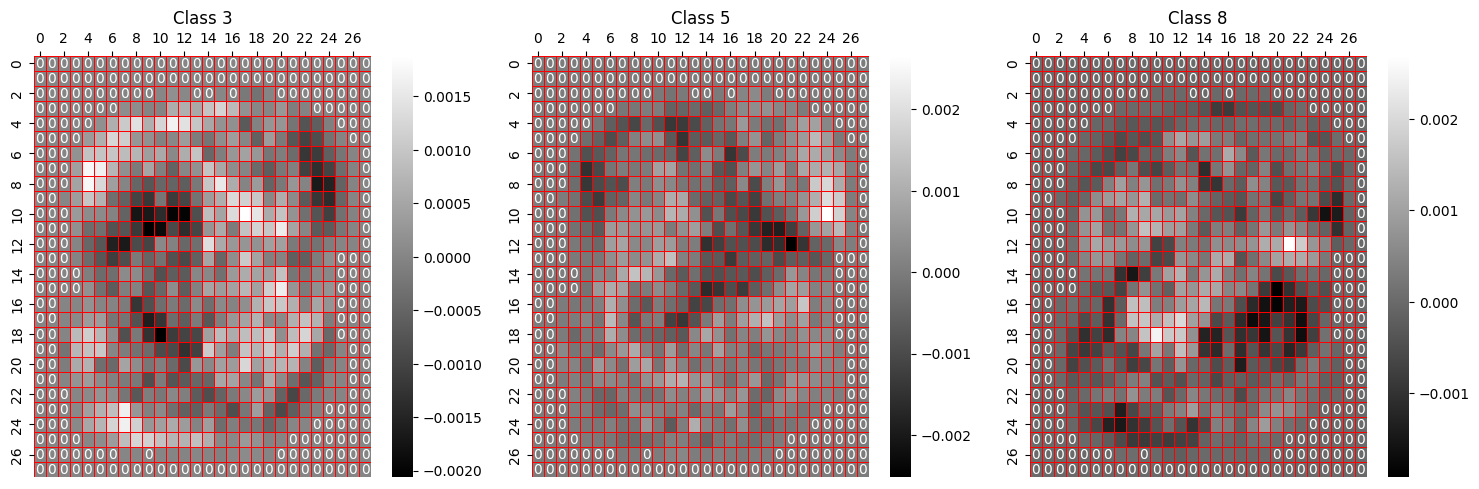

In [ ]:
# 训练 Group Lasso
group_lasso = LogisticGroupLasso(groups=np.arange(X_train_scaled.shape[1]),
                                 group_reg=0.01, l1_reg=0,
                                 supress_warning=True)
group_lasso.fit(X_train, y_train)

# 预测 logits
y_pred_gl = group_lasso.predict(X_test)

# 计算准确率
accuracy_gl = accuracy_score(y_test, y_pred_gl)

# 计算混淆矩阵
labels = np.unique(y_train)
cm_gl = confusion_matrix(y_test, y_pred_gl, labels=labels)

# 计算被 Group Lasso 归零的特征比例
zero_features = np.all(group_lasso.coef_ == 0, axis=1)  # 确保所有类别都为 0
zero_ratio = zero_features.sum() / (28*28) * 100
print(f"There are {zero_ratio:.2f}% features that are entirely zeroed out")

# 输出结果
print("Group-Lasso Multinomial Logistic Regression Accuracy:", accuracy_gl)
print("Confusion Matrix:")
print(cm_gl)
records.append(("group_lasso", accuracy_gl, cm_gl))

# 计算所有类别都被 Group Lasso 消零的特征
zero_features = np.all(group_lasso.coef_ == 0, axis=1)  # 现在 zero_features 是 (784,)

# 重新 reshape 成 28x28 形式
zero_mask = zero_features.reshape(28, 28)

# 可视化
fig, axes = plt.subplots(1, group_lasso.coef_.shape[1], figsize=(15, 5))

for i in range(group_lasso.coef_.shape[1]):  # 遍历类别
    ax = axes[i]

    # 创建 annot 矩阵，只在归零的像素位置标注 "0"
    annot_matrix = np.where(zero_mask, "0", "")

    # 绘制 Heatmap
    sns.heatmap(
        group_lasso.coef_[:, i].reshape(28, 28), cmap="gray", ax=ax, annot=annot_matrix,
        fmt="", cbar=True, linewidths=0.5, linecolor="red"
    )

    # 设置标题 & X 轴在上方
    ax.set_title(f"Class {labels[i]}")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

plt.tight_layout()
plt.show()